# Pre-process and write to npz for GNN training and testing

In [91]:
import re
import numpy as np
import random

re_int_sci = r'[-\d\.]+e?[-+\d]*'
re_sci = r'[+-]?\d+\.\d+e[+-]?[\d]+'

def parse_fragment_simulation(file):
    '''
    Extract info from LSDYNA txt, including particle coordinates, particle types, and effective plastic strain (eps)."
    Input: txt file extracted from LSDYNA d3plot.
    Output: np arrays of shapes, 
            tracjectory (timesteps, num_particles, 3), 
            particle_type (num_particles,), 
            eps (timesteps, num_particles).
    '''
                   
    with open(file, 'r') as f:
        lines = f.readlines() 

    # Find all "particle position" lines and "plastic strain" lines using key words
    pos_lines_start, pos_lines_end = [], []
    strain_lines_start, strain_lines_end = [], []
    for idx, line in enumerate(lines):
        if line.startswith("*NODE"):
            pos_lines_start.append(idx)
        elif line.startswith("*END"):  
            pos_lines_end.append(idx)
        elif line.startswith("$SPH_ELEMENT_RESULTS"):
            strain_lines_start.append(idx)

    num_steps = len(pos_lines_start)
    pos_lines_end, strain_lines_end = pos_lines_end[:num_steps], pos_lines_end[num_steps:]

    # Extact particle positions 
    trajectory = []
    for line_start, line_end in zip(pos_lines_start, pos_lines_end):
        pos_lines = lines[line_start:line_end]   # lines that contains positions in one time step
        pos_one_step = []
        for line in pos_lines:
            num_str = re.findall(re_int_sci, line)
            if len(num_str) == 4:
                pos = [float(x) for x in num_str] #last one is volume
                pos = tuple(pos)
                pos_one_step.append(pos)
        trajectory.append(pos_one_step) 
    trajectory = np.array(trajectory).astype(float)

    # Extract effective plastic strain (eps)
    strains = []
    for line_start, line_end in zip(strain_lines_start, strain_lines_end):
        strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        strains_one_step = []
        for line in strain_lines:
            num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
            if len(num_str) == 2:
                num = [float(x) for x in num_str] #last one is volume
                num = tuple(num)
                strains_one_step.append(num)
        strains.append(strains_one_step)  
    strains = np.array(strains).astype(float)
    
    # Find beam particles by checking the difference between
    # all particles and solid particles
    # Set the strain for all beam particles as 0
    pos_dict = {item[0]: item[1:] for item in trajectory[0, :]}
    solid_strain_dict = {item[0]: item[1:] for item in strains[0, :]}
    type_dict = {}
    beam_strain_dict = {}

    for key in pos_dict:
        if key in solid_strain_dict:
            type_dict[key] = 0
        else:
            type_dict[key] = 1
            beam_strain_dict[key] = 0.

    beam_strain = np.array(list(beam_strain_dict.items())).astype(float)
    particle_type = np.array(list(type_dict.items())).astype(int)
    strains = np.concatenate((strains, np.tile(beam_strain, (strains.shape[0], 1, 1))), axis=1)
    
    # Sort based on eid
    sorted_idx = particle_type[:, 0].argsort()
    particle_type = particle_type[sorted_idx, 1]

    sorted_idx = strains[0, :, 0].argsort()
    strains = strains[:, sorted_idx, 1]

    sorted_idx = trajectory[0, :, 0].argsort()
    trajectory = trajectory[:, sorted_idx, 1:]
    
    # Define boundary particle as another type (kinematic)
    mask = (trajectory[0, :, 1] >= 850) | (trajectory[0, :, 1] <= -850)
    particle_type[mask] = 2
        
    return trajectory, particle_type, strains


if __name__ == "__main__":
    pass

In [ ]:
import numpy as np
import pandas as pd
import glob
import json
import random
import math
import pathlib

dataset = 'Fragment-Step10-80-2'
in_dir = f'/home/jovyan/work/data_temp/fragment/60/'
out_dir = f'/home/jovyan/work/data_temp/fragment/{dataset}/'
metafile = '/home/jovyan/work/data_temp/fragment/GNN_Fragment.xlsx'
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)

# Read metadata as dict with key as the filename, and value as list of 
# ID, X, Y, Z, L, R, Mass, Concrete Strength
metadata = pd.DataFrame()
for sheet in ['60mm', '90mm', '120mm']:   
    df = pd.read_excel(metafile, sheet_name=sheet, skiprows=0, header=2)
    df = df.iloc[:, 5:12]
    df = df.rename(columns={'Unnamed: 5': 'ID'})
    df = df.dropna(subset=['ID'])
    df['ID'] = [str(x).rsplit('_', 1)[0] + str(x).rsplit('_', 1)[-1] for x in df['ID']]
    df['ID'] = sheet.split('m')[0] + '_' + df['ID']
    for col in ['Z (mm)','L (mm)','R (mm)','Mass (kg)']:
        df[col] = df[col].fillna(method='ffill')
    df['Strength (MPa)'] = [float(str(x).split('C')[-1]) for x in df['ID']]
    metadata = pd.concat([metadata, df], ignore_index=True)
df_id = metadata['ID']
metadata = metadata.drop('ID', axis=1)
metadata = (metadata - metadata.mean()) / metadata.std()
metadata = pd.concat([df_id, metadata], axis=1)
metadata = metadata.groupby('ID').apply(lambda x: x.iloc[:, 1:].values.flatten().tolist()).to_dict()

# Grab all simulation cases from corresponding data folder
simulations = glob.glob(in_dir +'*')
random.shuffle(simulations)

## Larger step size leads to shorter trajectory and hence better rollout performance
## But lower precision of the simulation
STEP_SIZE = 2

## Initialisation placeholders for data
n_trajectory = len(simulations)
ds_train, ds_valid, ds_test = {}, {}, {}
vels = np.array([]).reshape(0, 3)
accs = np.array([]).reshape(0, 3)
strain_stats = np.array([])
file_train, file_valid, file_test = [], [], []

## Main loop for data extraction
for idx, simulation in enumerate(simulations):
    filename = simulation.split('/')[-1]
    print(f"{idx}/{n_trajectory} Reading {filename}...")
    positions, particle_type, strains = parse_fragment_simulation(simulation)
    dim = positions.shape[-1]
    
    positions = positions[10:80:STEP_SIZE, :, :]
    strains = strains[10:80:STEP_SIZE, :]
    meta = np.array(metadata[filename], dtype=float)   
    # meta = np.tile(meta, (particle_type.shape[0], 1))
    #strains = (strains - strain_mean) / strain_std   ## standardize based on overall mean and std
    
    # print for debug
    # print(f"Dim: {dim}")
    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"Strain min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"Shape, pos: {positions.shape}, types: {particle_type.shape}, strain: {strains.shape}, meta: {meta.shape}")
    print(f"Unique particle types: {np.unique(particle_type)}")
    # print('Meta: ', meta)
    
    # Data splits: train(80%), valid(10%), test(10%)
    key = f'{idx}_{filename}' 
    if idx < 40:
        print('to train')
        ds_train[key] = {}
        ds_train[key]['positions'] = positions
        ds_train[key]['particle_type'] = particle_type
        ds_train[key]['strains'] = strains
        ds_train[key]['meta'] = meta
        file_train.append(filename)
    if idx >= 40:
        print('to val')
        ds_valid[key] = {}
        ds_valid[key]['positions'] = positions
        ds_valid[key]['particle_type'] = particle_type
        ds_valid[key]['strains'] = strains
        ds_valid[key]['meta'] = meta
        file_valid.append(filename)
    if idx >= 40:
        print('to test')
        ds_test[key] = {}
        ds_test[key]['positions'] = positions
        ds_test[key]['particle_type'] = particle_type
        ds_test[key]['strains'] = strains
        ds_test[key]['meta'] = meta
        file_test.append(filename)
    # Extract Vel and Acc statistics
    # positions of shape [timestep, particles, dimensions]
    vel_trajectory = positions[1:,:,:] - positions[:-1,:,:]
    acc_trajectory = vel_trajectory[1:,:,:] - vel_trajectory[:-1,:,:]
    
    vels = np.concatenate((vels, vel_trajectory.reshape(-1, dim)), axis=0)
    accs = np.concatenate((accs, acc_trajectory.reshape(-1, dim)), axis=0)

# Extract vel, acc statistics for normalisation
vel_mean, vel_std = list(vels.mean(axis=0)), list(vels.std(axis=0))
acc_mean, acc_std = list(accs.mean(axis=0)), list(accs.std(axis=0))

# Save datasets in numpy format
flattened_data_train = {}
for sim_key, sim_data in ds_train.items():
    for data_key, array in sim_data.items():
        flattened_data_train[f"{sim_key}_{data_key}"] = array
        
flattened_data_val = {}
for sim_key, sim_data in ds_valid.items():
    for data_key, array in sim_data.items():
        flattened_data_val[f"{sim_key}_{data_key}"] = array
        
flattened_data_test = {}
for sim_key, sim_data in ds_test.items():
    for data_key, array in sim_data.items():
        flattened_data_test[f"{sim_key}_{data_key}"] = array

np.savez(out_dir + 'train.npz', **flattened_data_train)
np.savez(out_dir + 'valid.npz', **flattened_data_val)
np.savez(out_dir + 'test.npz', **flattened_data_test)

print(f"{len(ds_train)} trajectories saved to train.npz.")
print(f"{len(ds_valid)} trajectories saved to valid.npz.")
print(f"{len(ds_test)}  trajectories saved to test.npz.")

# Save meta data
in_file = '/home/jovyan/share/gns_data/Concrete2D-C/metadata.json'
out_file = out_dir + 'metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

# In GNN, the suggested connection radius is 4.5r, or 5.625 mm (aounrd 20 neighbors)
# If R is 5 mm before normalization, 
meta_data['dim'] = 3
meta_data['default_connectivity_radius'] = 11 
meta_data['sequence_length'] = positions.shape[0]
meta_data['vel_mean'] = vel_mean
meta_data['vel_std'] = vel_std
meta_data['acc_mean'] = acc_mean
meta_data['acc_std'] = acc_std
# meta_data['strain_mean'] = strain_mean
# meta_data['strain_std'] = strain_std

meta_data['dt'] = 0.0006 * STEP_SIZE
meta_data['bounds'] = [[-500, 500], [-1000, 1000], [4, 124]]
meta_data['file_train'] = file_train
meta_data['file_valid'] = file_valid
meta_data['file_test'] = file_test
print(meta_data)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

# Read MPS

In [ ]:
import re
import numpy as np
import random

re_int_sci = r'[-\d\.]+e?[-+\d]*'
re_sci = r'[+-]?\d+\.\d+e[+-]?[\d]+'

def parse_fragment_mps(file):
    '''
    Extract info from LSDYNA txt, including particle coordinates, particle types, and effective plastic strain (eps)."
    Input: Txt from LYDYNA, e.g., C_80_480_Cc_20_strain.txt
    Output: np arrays of shapes, 
            tracjectory (timesteps, num_particles, 3), particle_type (num_particles,), eps (timesteps, num_particles).
    '''
                   
    with open(file, 'r') as f:
        lines = f.readlines() 

    # Find all "particle position" lines and "plastic strain" lines using key words
    strain_lines_start, strain_lines_end = [], []
    for idx, line in enumerate(lines):
        if line.startswith("$RESULT OF  Max Prin Strain"):
            strain_lines_start.append(idx)
        elif line.startswith("*END"):
            strain_lines_end.append(idx)

    # Extract effective plastic strain (eps)
    strains = []
    for line_start, line_end in zip(strain_lines_start, strain_lines_end):
        strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        strains_one_step = []
        for line in strain_lines:
            num_str = re.findall(re_sci, line)  # Regular expression findign scitific numbers
            if len(num_str) == 1:
                num = float(num_str[0]) 
                strains_one_step.append(num)
        strains_one_step = [0]*6248 + strains_one_step   # Add zero strain to all beam particles
        strains.append(strains_one_step)  
    strains = np.array(strains).astype(float)
    
    return strains


if __name__ == "__main__":
    pass

In [ ]:
file = '/home/jovyan/work/data_temp/fragment/120_4_0.3C50'
trajectory, particle_types, strains = parse_fragment_simulation(file)
print(trajectory.shape, particle_types.shape, strains.shape)

# Modify metadata

In [100]:
in_file = '/home/jovyan/share/8TB-share/qilin/fragment/060-Step-06-76-2-pos-normalised/metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

meta_data['bounds'] = [[-500, 500], [-1000, 1000], [4, 410]]
for key, value in meta_data.items():
    print(key, value)
    
with open(in_file, 'w') as f:
    json.dump(meta_data, f)

dim 3
default_connectivity_radius 11
sequence_length 70
vel_mean [0.00030258110923764563, -5.577866437243203e-05, 0.1144118514429346]
vel_std [0.040302280477414194, 0.042869497728188904, 0.2690081565659017]
acc_mean [4.852914787781672e-06, 3.755691599808809e-07, 0.0015101802059697815]
acc_std [0.011015259486335539, 0.014261184230658438, 0.018874535652524924]
dt 0.0006
bounds [[-500, 500], [-1000, 1000], [4, 410]]
file_train ['029_60_2_0.5C30.npz', '026_60_3_0.3C80.npz', '044_60_6_0.5C80.npz', '025_60_4_0.3C50.npz', '043_60_4_0.5C30.npz', '012_60_5_0.5C50.npz', '023_60_2_0.5C50.npz', '038_60_4_0.5C50.npz', '017_60_3_0.5C30.npz', '000_60_5_0.4C50.npz', '041_60_6_0.5C50.npz', '030_60_5_0.4C30.npz', '031_60_2_0.3C30.npz', '007_60_5_0.3C80.npz', '032_60_6_0.3C30.npz', '020_60_4_0.5C80.npz', '022_60_6_0.5C30.npz', '035_60_2_0.4C50.npz', '013_60_6_0.4C50.npz', '021_60_4_0.3C80.npz', '006_60_5_0.5C30.npz', '014_60_6_0.3C80.npz', '028_60_2_0.3C50.npz', '027_60_5_0.3C30.npz', '008_60_2_0.4C80.np

# Test regular expression for number extraction

In [ ]:
import re

strs = ['20742   1.4952594e+03   -1.0499660e+02   1.6313647e-02   9.9995575e+02',
        '    32365   1.4051317e+00',
        '   10826       1   15757   15758   15784   15783   11311   11312   11338   11337',
        '$Total Solid element Volume =    7.5878880e+07'
       ]

pattern = r'[+-]?\d+\.\d+e[+-]?[\d]+'
for str in strs:
    print(re.findall(pattern, str))
    
pattern = r'[-\d\.]+e?[-+\d]*'
for str in strs:
    print(re.findall(pattern, str))

# Plot Fragment data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


# Create a colormap
cmap = plt.get_cmap("rainbow")

# Create a 3D scatter plot with custom figure size
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 2, 0.1])

# Initial scatter plot
scatter = ax.scatter([], [], [], c=[], cmap=cmap, vmin=strains.min(), vmax=strains.max())

# Add a colorbar
cbar = fig.colorbar(scatter)
cbar.set_label("Strain")

# Set axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


def update(timestep):
    ax.clear()
    ax.set_box_aspect([4, 8, 1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    ax.set_title(f"Time step: {timestep}")

    pos = position[timestep]
    strains_t = strain[timestep]
    scatter = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=strains_t, cmap=cmap)

    return scatter,


ani = FuncAnimation(fig, update, frames=range(strains.shape[0]), interval=200, blit=False)

# Uncomment the following line to save the animation as a GIF
ani.save("pred.gif", writer="pillow", fps=5, dpi=50)

In [ ]:
import matplotlib.pyplot as plt

step = 20
mask = type == 0

xyz = positions[step, mask]
strain_t = strain[step, mask]

# Create a colormap
cmap = plt.get_cmap("rainbow")

# Create a 3D scatter plot with custom figure size
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1, 2, 0.1])

# Initial scatter plot
scatter = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=strain_t, cmap=cmap, vmin=strain_t.min(), vmax=strain_t.max())

# Add a colorbar
cbar = fig.colorbar(scatter)
cbar.set_label("Strain")

# Set axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

In [ ]:
import pandas as pd

metafile = '/home/jovyan/work/data_temp/fragment/GNN_Fragment.xlsx'

metadata = pd.DataFrame()
for sheet in ['60mm', '90mm', '120mm']:   
    df = pd.read_excel(metafile, sheet_name=sheet, skiprows=0, header=2)
    df = df.iloc[:, 5:12]
    df = df.rename(columns={'Unnamed: 5': 'ID'})
    df = df.dropna(subset=['ID'])
    df['ID'] = [str(x).rsplit('_', 1)[0] + str(x).rsplit('_', 1)[-1] for x in df['ID']]
    df['ID'] = sheet.split('m')[0] + '_' + df['ID']
    for col in ['Z (mm)','L (mm)','R (mm)','Mass (kg)']:
        df[col] = df[col].fillna(method='ffill')
    df['Strength (MPa)'] = [float(str(x).split('C')[-1]) for x in df['ID']]
    metadata = pd.concat([metadata, df], ignore_index=True)
df_id = metadata['ID']
metadata = metadata.drop('ID', axis=1)
metadata = (metadata - metadata.mean()) / metadata.std()
metadata = pd.concat([df_id, metadata], axis=1)
print(metadata.describe())
metadata = metadata.groupby('ID').apply(lambda x: x.iloc[:, 1:].values.flatten().tolist()).to_dict()

simulation = '90_6_0.3C50'
meta = metadata[simulation]
print(meta)

[0.44644429 0.46142332 0.47181436 0.47382453 0.47781876 0.47578091
 0.47891462 0.47603125 0.47934315 0.47963375 0.47429948 0.47847962
 0.48003438 0.47431087 0.47794187 0.47384534 0.47485054 0.47650833
 0.47533079 0.4726823  0.47803311 0.47657721 0.47347944 0.47223819
 0.47113966 0.47638641 0.32342382]


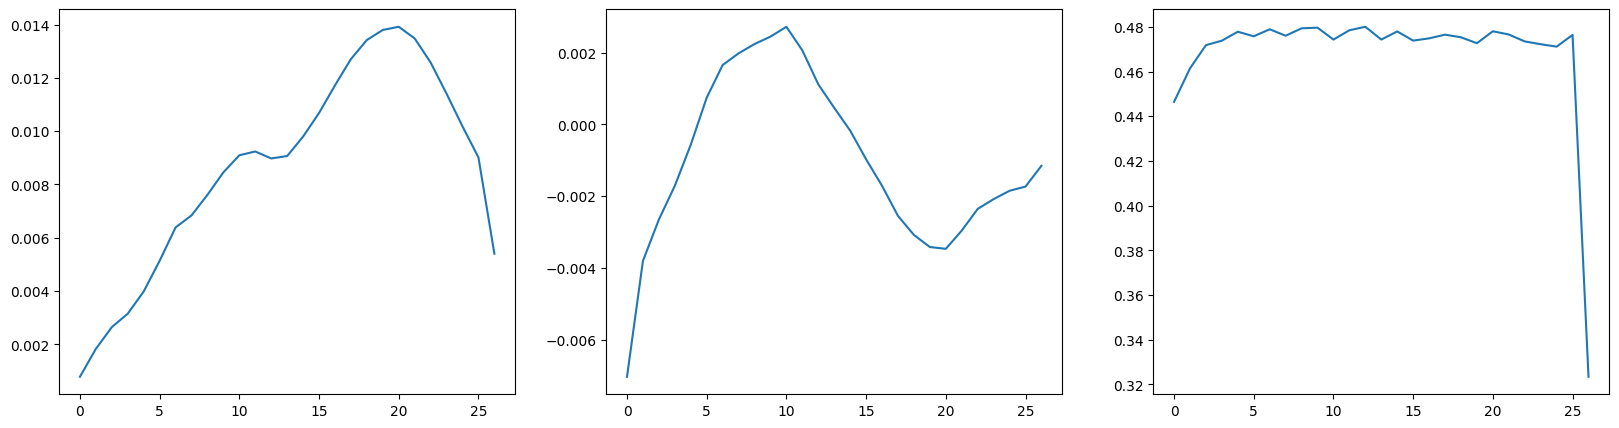

In [83]:
import numpy as np


path = '/home/jovyan/work/data_temp/fragment/Fragment/train.npz'
data = [item for _, item in np.load(path, allow_pickle=True).items()]

trac_idx = 4
pos = data[trac_idx][0]
vel = pos[1:, :, :] - pos[:-1, :, :]
vel = vel.mean(axis=1)

fig = plt.figure(figsize=(20, 5))
for axis in range(3):
    ax = fig.add_subplot(1,3,axis+1)
    ax.plot(vel[:, axis])

In [42]:
file = '/home/jovyan/work/data_temp/fragment/60/60_2_0.3C30'
pos, type, strain = parse_fragment_simulation(file)
print(pos.shape)

(102, 123069, 3)


In [46]:
sum(type == 2)

18432

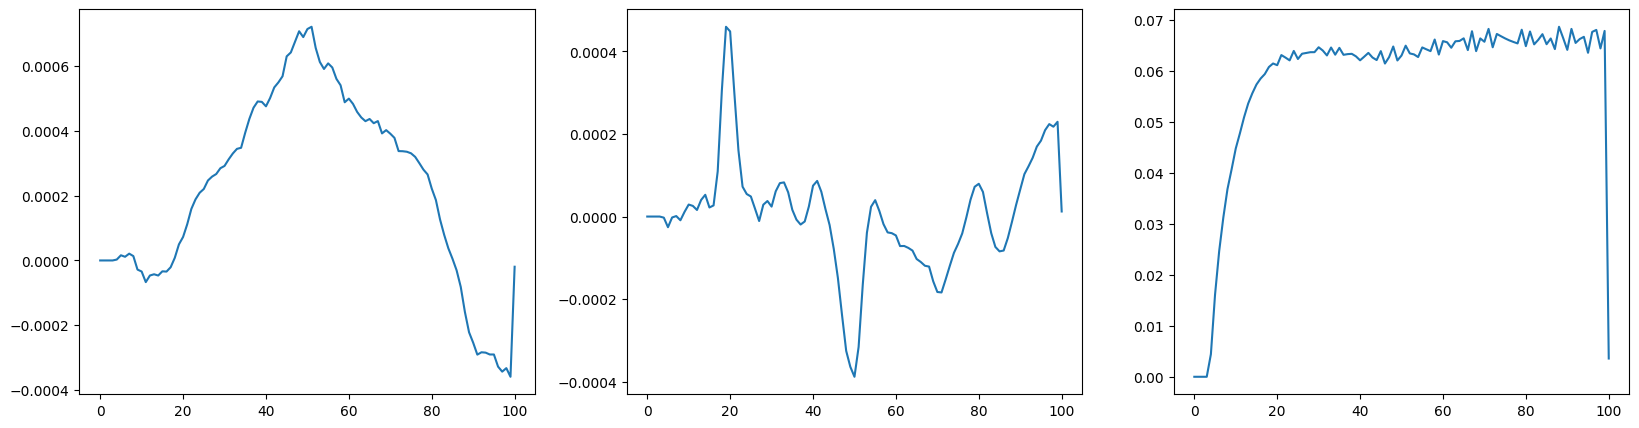

In [60]:
vel = pos[1:, :, :] - pos[:-1, :, :]
vel = vel.mean(axis=1)

fig = plt.figure(figsize=(20, 5))
for axis in range(3):
    ax = fig.add_subplot(1,3,axis+1)
    ax.plot(vel[:, axis])

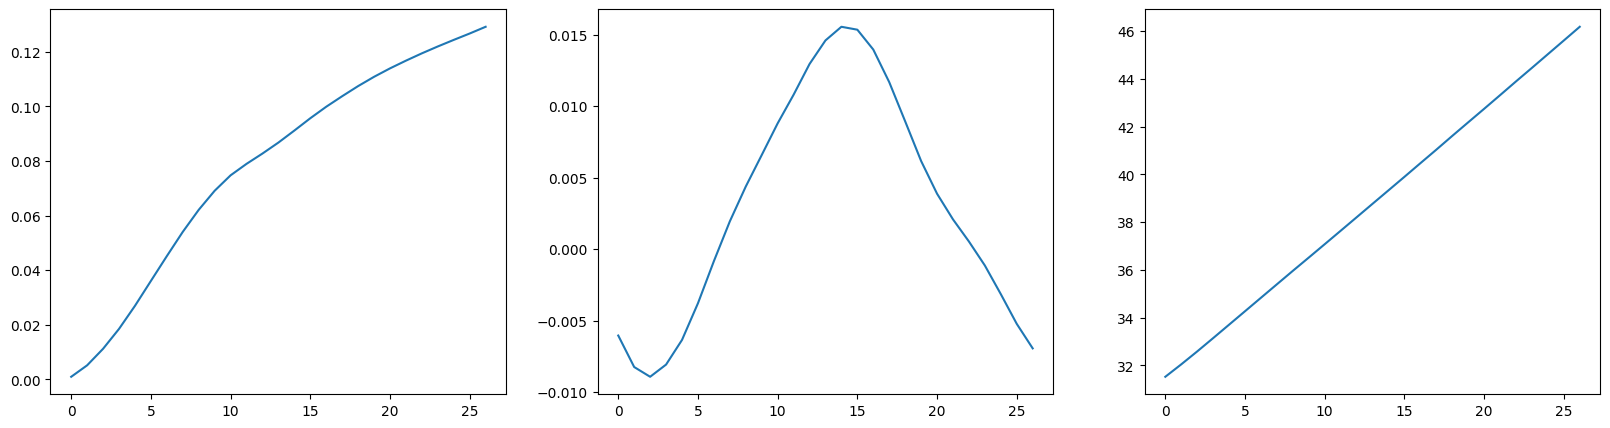

In [152]:
fig = plt.figure(figsize=(20, 5))
poss = pos.mean(axis=1)
for axis in range(3):
    ax = fig.add_subplot(1,3,axis+1)
    ax.plot(poss[:, axis])

In [3]:
import numpy as np

path = '/home/jovyan/work/data_temp/fragment/Fragment/test.npz'
data = np.load(path)
data_list = []
current_list = []
for array in data.values():
    current_list.append(array)
    if len(current_list) == 4:
        data_list.append(current_list)
        current_list = []

(array([2.1000e+01, 6.5000e+01, 3.2000e+02, 5.2136e+04, 6.9898e+04,
        6.0700e+02, 1.6000e+01, 5.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.267148 , -0.2007846, -0.1344212, -0.0680578, -0.0016944,
         0.064669 ,  0.1310324,  0.1973958,  0.2637592,  0.3301226,
         0.396486 ]),
 <BarContainer object of 10 artists>)

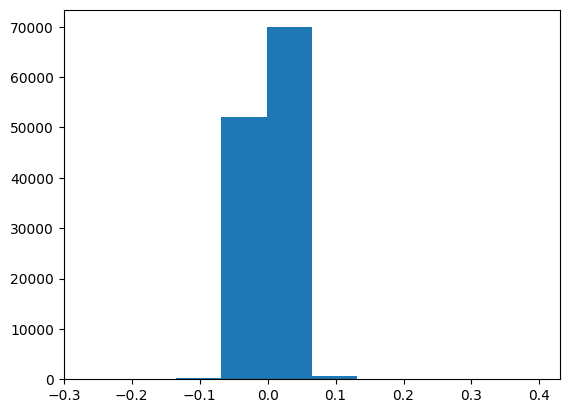

In [41]:
import matplotlib.pyplot as plt

pos = data_list[0][0]
strain = data_list[4][2]
vel = pos[1:, :, :] - pos[:-1, :, :]
acc = vel[1:, :, :] - vel[:-1, :, :]
plt.hist(acc[10, :, 2])

# Convert TXT data to npz

In [ ]:
import numpy as np
import pandas as pd
import glob
import json
import random
import math
import pathlib
import os

dataset = '060-test'
in_dir = f'/home/jovyan/work/data_temp/fragment/60/'
out_dir = f'/home/jovyan/share/8TB-share/qilin/fragment/{dataset}'
metafile = '/home/jovyan/work/data_temp/fragment/GNN_Fragment.xlsx'
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)

# Read metadata as dict with key as the filename, and value as list of 
# ID, X, Y, Z, L, R, Mass, Concrete Strength
metadata = pd.DataFrame()
for sheet in ['60mm', '90mm', '120mm']:   
    df = pd.read_excel(metafile, sheet_name=sheet, skiprows=0, header=2)
    df = df.iloc[:, 5:12]
    df = df.rename(columns={'Unnamed: 5': 'ID'})
    df = df.dropna(subset=['ID'])
    df['ID'] = [str(x).rsplit('_', 1)[0] + str(x).rsplit('_', 1)[-1] for x in df['ID']]
    df['ID'] = sheet.split('m')[0] + '_' + df['ID']
    for col in ['Z (mm)','L (mm)','R (mm)','Mass (kg)']:
        df[col] = df[col].fillna(method='ffill')
    df['Strength (MPa)'] = [float(str(x).split('C')[-1]) for x in df['ID']]
    metadata = pd.concat([metadata, df], ignore_index=True)
df_id = metadata['ID']
metadata = metadata.drop('ID', axis=1)
metadata = (metadata - metadata.mean()) / metadata.std()
metadata = pd.concat([df_id, metadata], axis=1)
metadata = metadata.groupby('ID').apply(lambda x: x.iloc[:, 1:].values.flatten().tolist()).to_dict()

# Grab all simulation cases from corresponding data folder
simulations = glob.glob(in_dir +'*')
random.shuffle(simulations)

## Initialisation placeholders for data
n_trajectory = len(simulations)

## Main loop for data extraction
for idx, simulation in enumerate(simulations):
    data = {}
    filename = simulation.split('/')[-1]
    print(f"{idx}/{n_trajectory} Reading {filename}...")
    positions, particle_type, strains = parse_fragment_simulation(simulation)
    meta_feature = np.array(metadata[filename], dtype=float)   
    data['positions'] = positions
    data['particle_type'] = particle_type
    data['strains'] = strains
    data['meta_feature'] = meta_feature

    out_path = os.path.join(out_dir, f'{idx:03}_{filename}.npz')
    with open(out_path, 'wb') as f:
        np.savez(f, positions=positions, particle_type=particle_type, strains=strains, meta_feature=meta_feature)

    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"Strain min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"Shape, pos: {positions.shape}, types: {particle_type.shape}, strain: {strains.shape}, meta: {meta_feature.shape}")
    print(f"Unique particle types: {np.unique(particle_type)}")
    print('Meta feature: ', meta_feature)
    print('Num kinematic: ', sum(particle_type == 2))

# Extract npz to dataset

In [160]:
import numpy as np
import pandas as pd
import glob
import json
import random
import math
import pathlib


dataset = 'Step-0-100-3'
in_dir = f'/home/jovyan/share/8TB-share/qilin/fragment/npz/'
out_dir = f'/home/jovyan/share/8TB-share/qilin/fragment/{dataset}/'
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)

# Grab all simulation cases from corresponding data folder
simulations = glob.glob(in_dir +'**/*.npz', recursive=True)
random.shuffle(simulations)

## Larger step size leads to shorter trajectory and hence better rollout performance
## But lower precision of the simulation
STEP_SIZE = 3

## Initialisation placeholders for data
n_trajectory = len(simulations)
ds_train, ds_valid, ds_test = {}, {}, {}
poss = np.array([]).reshape(0, 3)
vels = np.array([]).reshape(0, 3)
accs = np.array([]).reshape(0, 3)
strain_stats = np.array([])
file_train, file_valid, file_test = [], [], []

## Main loop for data extraction
for idx, simulation in enumerate(simulations):
    filename = simulation.split('/')[-1]
    print(f"{idx}/{n_trajectory} Reading {filename}...")
    data = np.load(simulation)
    positions = data['positions'][:100:STEP_SIZE, :, :]
    strains = data['strains'][:100:STEP_SIZE, :]
    
    # Obtain residual strain, which original strain = residual_strain.cumsum(axis=0)
    strains_diff = strains[1:, :] - strains[:-1, :]
    strains_diff[strains_diff < 0] = 0
    strains = np.concatenate((strains[:1, :], strains_diff), axis=0)
    
    particle_type = data['particle_type']
    # Convert the bottom layer to kinematic
    # mask = data['positions'][0, :, 2] < 5.05
    # particle_type[mask] = 2
    
    meta_feature = data['meta_feature']  
    dim = positions.shape[-1]
    
    # print for debug
    # print(f"Dim: {dim}")
    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"Strain min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"Shape, pos: {positions.shape}, types: {particle_type.shape}, strain: {strains.shape}, meta: {meta_feature.shape}")
    print(f"Unique particle types: {np.unique(particle_type)}")
    print(f"Num particles, solid: {sum(particle_type==0)}, beam: {sum(particle_type==1)}, boundary: {sum(particle_type==2)} ")
    print(f"Meta feature, {meta_feature}")
    
    # Data splits: train(80%), valid(10%), test(10%)
    key = f'{idx}_{filename}' 
    if idx < 120:
        print('to train')
        ds_train[key] = {}
        ds_train[key]['positions'] = positions
        ds_train[key]['particle_type'] = particle_type
        ds_train[key]['strains'] = strains
        ds_train[key]['meta'] = meta_feature
        file_train.append(filename)
    if idx >= 120:
        print('to val')
        ds_valid[key] = {}
        ds_valid[key]['positions'] = positions
        ds_valid[key]['particle_type'] = particle_type
        ds_valid[key]['strains'] = strains
        ds_valid[key]['meta'] = meta_feature
        file_valid.append(filename)
    if idx >= 120:
        print('to test')
        ds_test[key] = {}
        ds_test[key]['positions'] = positions
        ds_test[key]['particle_type'] = particle_type
        ds_test[key]['strains'] = strains
        ds_test[key]['meta'] = meta_feature
        file_test.append(filename)
    # Extract Vel and Acc statistics
    # positions of shape [ntimesteps, nparticles, ndims]
    vel_trajectory = positions[1:,:,:] - positions[:-1,:,:]
    acc_trajectory = vel_trajectory[1:,:,:] - vel_trajectory[:-1,:,:]
    
    poss = np.concatenate((poss, positions.reshape(-1, dim)), axis=0)
    vels = np.concatenate((vels, vel_trajectory.reshape(-1, dim)), axis=0)
    accs = np.concatenate((accs, acc_trajectory.reshape(-1, dim)), axis=0)

# Extract vel, acc statistics for normalisation
pos_mean, pos_std = list(poss.mean(axis=0)), list(poss.std(axis=0))
vel_mean, vel_std = list(vels.mean(axis=0)), list(vels.std(axis=0))
acc_mean, acc_std = list(accs.mean(axis=0)), list(accs.std(axis=0))

# Save datasets in numpy format
flattened_data_train = {}
for sim_key, sim_data in ds_train.items():
    for data_key, array in sim_data.items():
        flattened_data_train[f"{sim_key}_{data_key}"] = array
        
flattened_data_val = {}
for sim_key, sim_data in ds_valid.items():
    for data_key, array in sim_data.items():
        flattened_data_val[f"{sim_key}_{data_key}"] = array
        
flattened_data_test = {}
for sim_key, sim_data in ds_test.items():
    for data_key, array in sim_data.items():
        flattened_data_test[f"{sim_key}_{data_key}"] = array

np.savez(out_dir + 'train.npz', **flattened_data_train)
np.savez(out_dir + 'valid.npz', **flattened_data_val)
np.savez(out_dir + 'test.npz', **flattened_data_test)

print(f"{len(ds_train)} trajectories saved to train.npz.")
print(f"{len(ds_valid)} trajectories saved to valid.npz.")
print(f"{len(ds_test)}  trajectories saved to test.npz.")

# Save meta data
out_file = out_dir + 'metadata.json'

meta_data = {}
meta_data['dim'] = dim
meta_data['default_connectivity_radius'] = 11 
meta_data['sequence_length'] = positions.shape[0]
meta_data['pos_mean'] = pos_mean
meta_data['pos_std'] = pos_std
meta_data['vel_mean'] = vel_mean
meta_data['vel_std'] = vel_std
meta_data['acc_mean'] = acc_mean
meta_data['acc_std'] = acc_std
meta_data['dt'] = 0.0006 * STEP_SIZE
meta_data['bounds'] = [[-500, 500], [-1000, 1000], [4, 407]]
meta_data['file_train'] = file_train
meta_data['file_valid'] = file_valid
meta_data['file_test'] = file_test
for key, value in meta_data.items():
    print(key, value)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

0/135 Reading 040_90_3_0.4C80.npz...
Position min:[-5.0256671e+02 -9.9500000e+02  3.5132500e-02], max:[504.02789 995.      198.06779]
Strain min:0.0, max:1.9999999
Shape, pos: (34, 186138, 3), types: (186138,), strain: (34, 186138), meta: (7,)
Unique particle types: [0 1 2]
Num particles, solid: 153000, beam: 5274, boundary: 27864 
Meta feature, [ 0.17698194 -1.4295932   0.         -0.61425654 -0.61425654 -0.704483
  1.29295587]
to train
1/135 Reading 044_60_6_0.5C80.npz...
Position min:[-5.2333531e+02 -9.9500000e+02  8.7410257e-01], max:[515.50144 995.      285.74068]
Strain min:0.0, max:1.9979758
Shape, pos: (34, 123069, 3), types: (123069,), strain: (34, 123069), meta: (7,)
Unique particle types: [0 1 2]
Num particles, solid: 102000, beam: 2637, boundary: 18432 
Meta feature, [-0.69646521 -0.60571576 -1.22020035  1.28675208  1.28675208  1.408966
  1.29295587]
to train
2/135 Reading 003_60_3_0.3C30.npz...
Position min:[-498.42203 -995.         4.13488], max:[500.49006 995.      325.3

In [116]:
data = np.load('/home/jovyan/share/8TB-share/qilin/fragment/npz/060/000_60_5_0.4C50.npz')

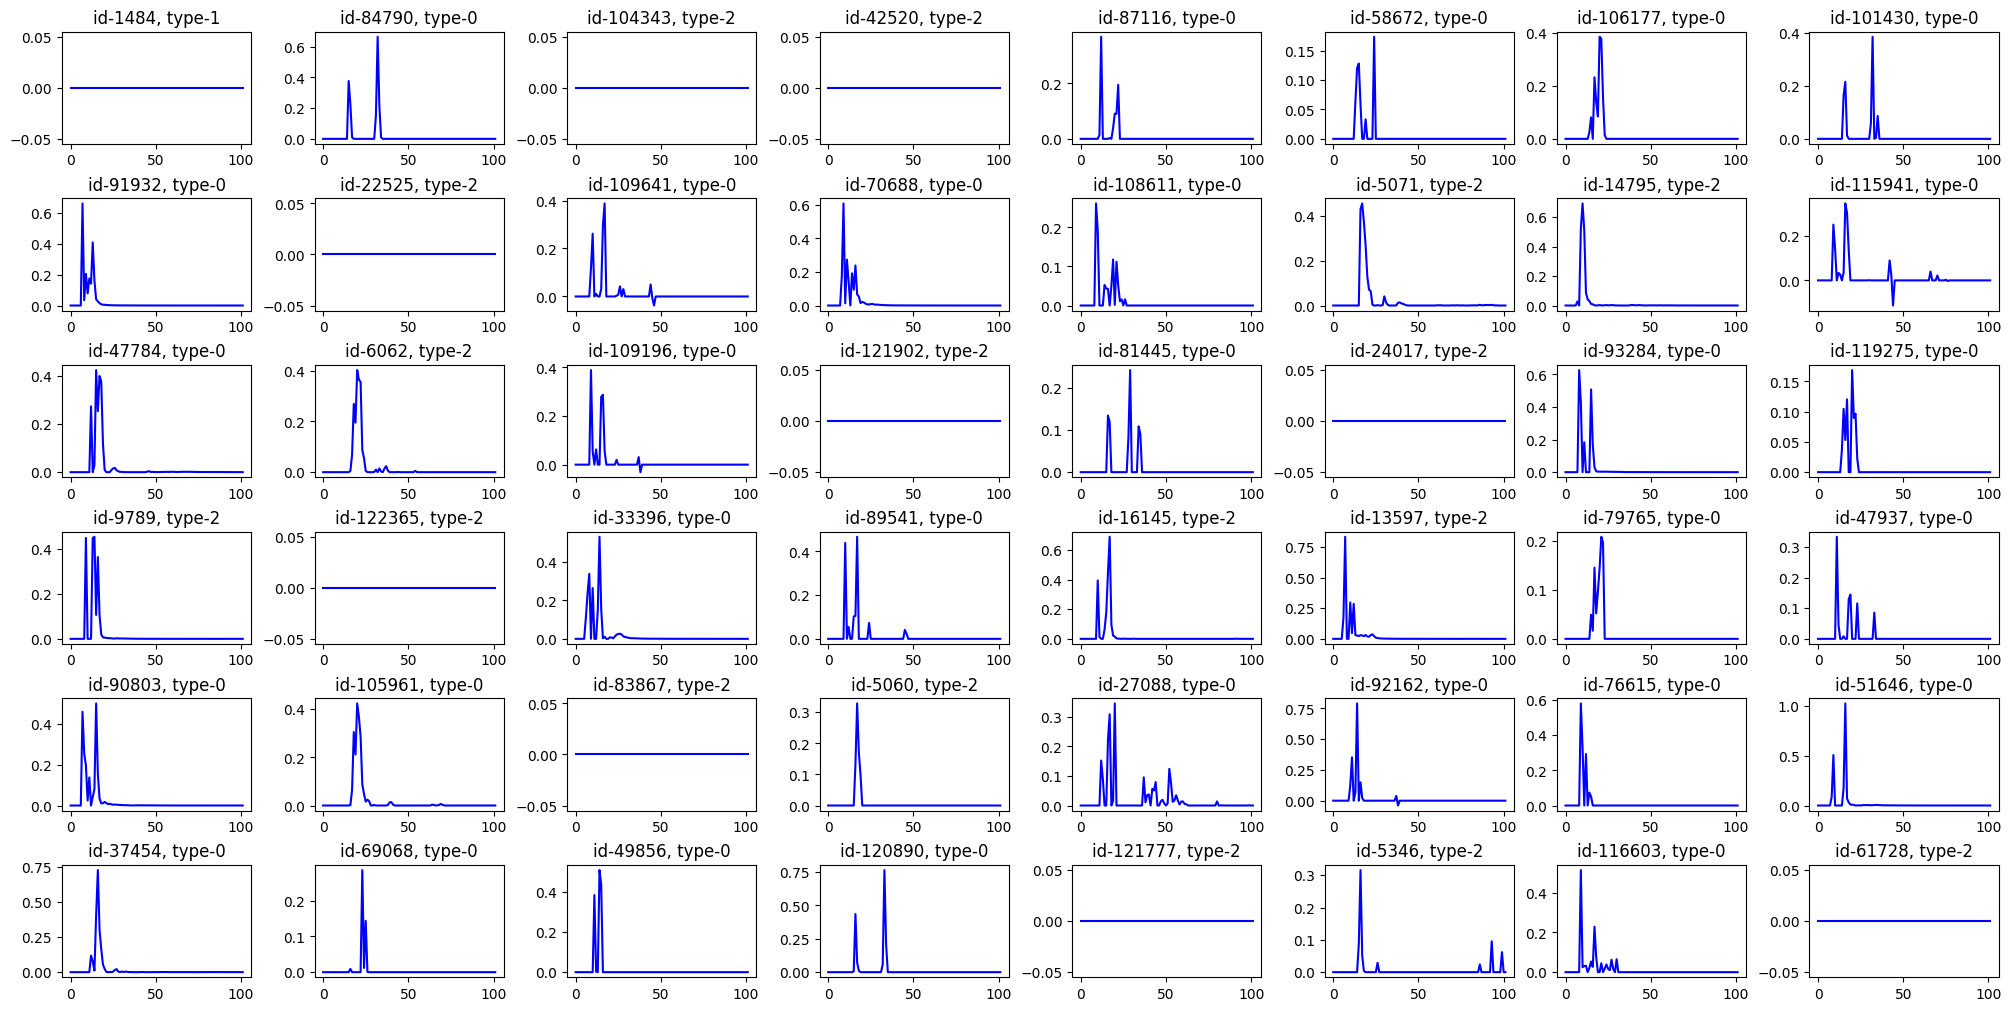

In [147]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10), constrained_layout=True)
idx = random.sample(range(123068), 48)
strains= strains.cumsum(axis=0)

for fig_id in range(48):
    ax = fig.add_subplot(6, 8, fig_id+1)
    ax.set_title(f'id-{idx[fig_id]}, type-{particle_type[idx[fig_id]]}')
    ax.plot(strain_diff[:, idx[fig_id]], 'b')

In [141]:
particle_type = data['particle_type']
# Convert the bottom layer to kinematic
mask = data['positions'][0, :, 2] < 5.05
particle_type[mask]=2
sum(particle_type==2)

35432